# MNIST

### MNIST 데이터 받기

In [1]:
import os
import sys
from six.moves import urllib
import gzip
import pickle
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt


SOURCE_URL = 'http://www.iro.umontreal.ca/~lisa/deep/data/mnist/mnist.pkl.gz'
FILENAME = SOURCE_URL.split('/')[-1]
DATA_DIR = './datasets'

def maybe_download(data_dir):
    filepath = os.path.join(data_dir, FILENAME)
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    if not os.path.isfile(filepath):
        def _progress(count, block_size, total_size):
            sys.stdout.write('\r>> Downloading {} {:.1f} %'.format(
                FILENAME, float(count * block_size) / float(total_size) * 100.0))
            sys.stdout.flush()
        filepath, _ = urllib.request.urlretrieve(SOURCE_URL, filepath, _progress)
        print()
        statinfo = os.stat(filepath)
        print('Successfully donloaded', FILENAME, statinfo.st_size, 'bytes.')

def load(data_dir, subset='train'):
    maybe_download(data_dir)
    filepath = os.path.join(data_dir, FILENAME)
    
    f = gzip.open(filepath, 'rb')
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    train_set, valid_set, test_set = u.load()
    f.close()
    
    if subset == 'train':
        trainx, trainy = train_set
        trainx = trainx.astype(np.float32).reshape(trainx.shape[0], 28, 28)
        trainy = trainy.astype(np.uint8)
        return trainx, trainy
    elif subset == 'test':
        testx, testy = test_set
        testx = testx.astype(np.float32).reshape(testx.shape[0], 28, 28)
        testy = testy.astype(np.uint8)
        return testx, testy
    elif subset== 'valid':
        validx, validy = valid_set
        validx = validx.astype(np.float32).reshape(validx.shape[0], 28, 28)
        validy = validy.astype(np.uint8)
        return validx, validy
    else:
        raise NotImplementedError('subset should be train or valid or test')

# Load data
train_data, train_label = load(DATA_DIR, 'train')
valid_data, valid_label = load(DATA_DIR, 'valid')
test_data, test_label = load(DATA_DIR, 'test')

# concatenate train and valid data as train data
train_data = np.concatenate((train_data, valid_data))
train_label = np.concatenate((train_label, valid_label))

### MNIST 데이터 확인 하기

In [2]:
# size of MNIST
print(train_data.shape)
print(train_label.shape)
print(test_data.shape)
print(test_label.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [13]:
len(train_data[100])

28

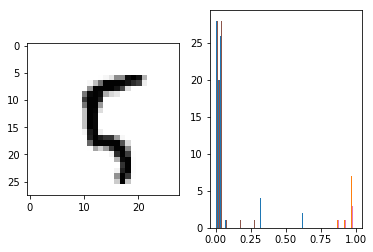

In [3]:
# show data
_, (ax1, ax2) = plt.subplots(1, 2)
sample_data = train_data[100]
ax1.imshow(sample_data, cmap=plt.cm.Greys);
ax2.hist(sample_data, bins=20, range=[0, 1]);

In [4]:
import tensorflow as tf

In [ ]:
def CNN(X,y,is_reuse):
    outs = tf.layers.conv2d(X, 128, 3, padding='same', name='conv1', reuse=tf.AUTO_REUSE) # (None, 28, 28, 128)
    outs = tf.nn.relu(outs)
    outs = tf.layers.max_pooling2d(outs, 2, 2) # (None, 14, 14, 128)

In [35]:
learning_rate = 1e-3
num_epochs = 100
batch_size = 100
num_display = 100

def get_model(X, by, is_reuse):
    X = tf.expand_dims(X, axis=3) # (None, 28, 28, 1)
    
    with tf.variable_scope('first'):
        outs = tf.layers.conv2d(X, 128, 3, padding='same', name='conv1', reuse=tf.AUTO_REUSE) # (None, 28, 28, 128)
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs, 2, 2) # (None, 14, 14, 128)
    with tf.variable_scope('second'):
        outs = tf.layers.conv2d(outs, 256, 3, padding='same', name='conv2', reuse=is_reuse)
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs, 2, 2) # (None, 7, 7, 256)
    with tf.variable_scope('third'):
        outs = tf.layers.conv2d(outs, 64, 3, padding='same', name='conv3', reuse=is_reuse)
        outs = tf.nn.relu(outs)
        outs = tf.layers.max_pooling2d(outs, 2, 2) # (None, 3, 3, 64)
    
    outs = tf.reshape(outs, (-1, outs.shape[1]*outs.shape[2]*outs.shape[3]))
    
    with tf.variable_scope('dense'):
        outs = tf.layers.dense(outs,128, name='dense1',reuse=is_reuse)
        outs = tf.nn.relu(outs)
        outs = tf.layers.dense(outs, 10, name='dense2',reuse=is_reuse)
    
    one_hot = tf.one_hot(by, 10)
    
    loss = tf.nn.softmax_cross_entropy_with_logits_v2(logits=outs, 
                                                      labels=one_hot)
    loss = tf.reduce_mean(loss)
    opt = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
    
    preds = tf.cast(tf.argmax(tf.nn.softmax(outs), axis=1), tf.int32)
    acc = tf.reduce_mean(tf.cast(tf.equal(by, preds), tf.float32))
    saver = tf.train.Saver(
            tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,'second')
            +tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,'thrid')
            +tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,'dense')
    )
    
    init = tf.global_variables_initializer()
    return {
        'loss': loss,
        'opt': opt,
        'preds': preds,
        'acc': acc,
        'init': init,
        'saver': saver
    }

In [36]:
X = tf.placeholder(tf.float32, shape=(None, 28, 28))
by = tf.placeholder(tf.int32)

model = get_model(X, by, True)

In [37]:
with tf.Session() as sess:
    sess.run(model['init'])
    for ind_epoch in range(0, num_epochs):
        print('Current iteration {}'.format(ind_epoch + 1))
        
        for ind_ in range(0, int(60000 / batch_size)):
            batch_X = train_data[ind_*batch_size:(ind_+1)*batch_size]
            batch_by = train_label[ind_*batch_size:(ind_+1)*batch_size]
            _, cur_loss, cur_acc = sess.run(
                [model['opt'], model['loss'], model['acc']],
                feed_dict={X: batch_X, by: batch_by})
            if ind_ % num_display == 0:
                print('loss {0:.4f} acc {1:.4f}'.format(cur_loss, cur_acc))
    model['saver'].save(sess, './ours.ckpt')

Current iteration 1
loss 2.3048 acc 0.0800
loss 2.3000 acc 0.1000
loss 2.2987 acc 0.0900
loss 2.2873 acc 0.1700
loss 2.2818 acc 0.1700
loss 2.2766 acc 0.2600
Current iteration 2
loss 2.2674 acc 0.2800
loss 2.2690 acc 0.2900
loss 2.2689 acc 0.2800
loss 2.2596 acc 0.3100
loss 2.2452 acc 0.3800
loss 2.2420 acc 0.4200
Current iteration 3
loss 2.2260 acc 0.4100
loss 2.2278 acc 0.3400
loss 2.2300 acc 0.4000
loss 2.2143 acc 0.3600
loss 2.1857 acc 0.4500
loss 2.1842 acc 0.4900
Current iteration 4
loss 2.1510 acc 0.5200
loss 2.1488 acc 0.4600
loss 2.1502 acc 0.5400
loss 2.1198 acc 0.4900
loss 2.0574 acc 0.5700
loss 2.0561 acc 0.6300
Current iteration 5
loss 1.9752 acc 0.7100
loss 1.9523 acc 0.6300
loss 1.9327 acc 0.6600
loss 1.8626 acc 0.6600
loss 1.6939 acc 0.7100
loss 1.6851 acc 0.6800
Current iteration 6
loss 1.4681 acc 0.8000
loss 1.3719 acc 0.7000
loss 1.3432 acc 0.6900
loss 1.2067 acc 0.8000
loss 0.9589 acc 0.7800
loss 1.0052 acc 0.7700
Current iteration 7
loss 0.7773 acc 0.8300
loss 0.74

loss 0.0466 acc 0.9800
loss 0.0351 acc 1.0000
Current iteration 53
loss 0.0837 acc 0.9800
loss 0.0769 acc 0.9800
loss 0.0946 acc 0.9700
loss 0.1164 acc 0.9600
loss 0.0456 acc 0.9800
loss 0.0344 acc 1.0000
Current iteration 54
loss 0.0828 acc 0.9800
loss 0.0751 acc 0.9800
loss 0.0933 acc 0.9700
loss 0.1166 acc 0.9600
loss 0.0447 acc 0.9800
loss 0.0337 acc 1.0000
Current iteration 55
loss 0.0819 acc 0.9800
loss 0.0736 acc 0.9800
loss 0.0921 acc 0.9800
loss 0.1169 acc 0.9600
loss 0.0440 acc 0.9800
loss 0.0333 acc 1.0000
Current iteration 56
loss 0.0810 acc 0.9800
loss 0.0721 acc 0.9800
loss 0.0909 acc 0.9800
loss 0.1169 acc 0.9600
loss 0.0432 acc 0.9800
loss 0.0328 acc 1.0000
Current iteration 57
loss 0.0802 acc 0.9800
loss 0.0705 acc 0.9800
loss 0.0898 acc 0.9800
loss 0.1170 acc 0.9600
loss 0.0425 acc 0.9800
loss 0.0324 acc 1.0000
Current iteration 58
loss 0.0794 acc 0.9800
loss 0.0693 acc 0.9800
loss 0.0885 acc 0.9800
loss 0.1170 acc 0.9600
loss 0.0417 acc 0.9800
loss 0.0318 acc 1.0000


In [44]:
with tf.Session() as sess:
    sess.run(model['init'])
    model['saver'].restore(sess,'./ours.ckpt')
    
    cur_acc_all = 0.0
    cur_loss_all = 0.0
    
    for ind_ in range(0, 10):
        cur_loss, cur_acc = sess.run(
                                    [model['loss'], model['acc']],
                                    feed_dict={X: test_data[ind_*1000:(ind_+1)*1000],
                                              by: test_label[ind_*1000:(ind_+1)*1000]})
        cur_loss_all += cur_loss
        cur_acc_all += cur_acc
    print('TEST: loss {0:.4f} acc {1:.4f}'.format(cur_loss_all /10.0,
                                                 cur_acc_all / 10.0))

INFO:tensorflow:Restoring parameters from ./ours.ckpt
TEST: loss 2.3139 acc 0.0826
